In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
test_file_path = '/content/drive/My Drive/bob_projects/test.xlsx'
train_file_path = '/content/drive/My Drive/bob_projects/train.xlsx'

Problem Statement:

    Get familiar with HAR, and maybe read some internet tutorials about how people usually solve this task.

    • Frame the problem (Regression, classification), the data, and the label or targets.

    • Get familiar with the dataset. Find if the dataset already includes the necessary features to perform HAR or if the raw data is enough to recognize activities. You may need to read some of the papers provided to determine if you need to compute the features from the data to perform HAR.

    • You may need to do further data pre-processing.

    • Check if some time series analysis (seasonality, etc.) is needed to improve the prediction.

    • Check the metrics you want to evaluate (depending on whether you are doing classification or regression).

    • Do some research about the architecture you want to use (You may want to use SimpleRNN, GRUs, LSMT, or Bidirectional RNNs)

1) Frame the problem:
    
    HAR is a multi-class classification problem - we are trying to classify different human activities.
    The 6 classifications present in the dataset are: Standing, Sitting, Laying, Walking, Walking Downstairs, and Walking Upstairs.

Data obtained directly from kaggle site at: https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones/data

Data was already split into training and testing sets and appeared clean after analysis - already normalized/standardized and ready to use as is

# EDA

In [ ]:
import pandas as pd
# read file into df
train_data = pd.read_excel(train_file_path)
test_data = pd.read_excel(test_file_path)


In [ ]:
# finding number of features in dataset
num_features = train_data.shape[1] - 1
print(num_features)   # 562 features, 6 classes, timestep = 128 from prompt

562


In [ ]:
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


# initial way: each of the 7352 samples to have 1 timestep with 562 features each

In [ ]:
# THIS ONE

import pandas as pd

# For the training set - initially removed subject since not important but had issues later, set labels up properly
X_train = train_data.drop(['Activity'], axis=1)
y_train = train_data['Activity']

# For the test set
X_test = test_data.drop(['Activity'], axis=1)
y_test = test_data['Activity']

# One-hot encode the labels
y_train_onehot = pd.get_dummies(y_train)
y_test_onehot = pd.get_dummies(y_test)


In [ ]:
# THIS ONE

# Convert DataFrames to NumPy arrays and then reshape for the RNN/LSTM running
X_train_reshaped = X_train.to_numpy().reshape((X_train.shape[0], 1, num_features))
X_test_reshaped = X_test.to_numpy().reshape((X_test.shape[0], 1, num_features))

# Baseline

In [ ]:
# THIS ONE

# predictions just 1 shift off
y_test_shifted = y_test.shift(1)

# first element na - below fixes that
y_test_shifted.fillna(y_test.iloc[0], inplace=True)

# convert to one-hot to 'predicct'
y_test_shifted_onehot = pd.get_dummies(y_test_shifted)

# accuracy
correct_predictions = (y_test_shifted_onehot.values == y_test_onehot.values).all(axis=1)
baseline_accuracy = correct_predictions.mean()

print(f'Baseline model accuracy: {baseline_accuracy}')


Baseline model accuracy: 0.9596199524940617


# Model 1: SimpleRNN

Epoch 1/10
115/115 [==============================] - 2s 7ms/step - loss: 0.7779 - accuracy: 0.6600 - val_loss: 0.3355 - val_accuracy: 0.8765
Epoch 2/10
115/115 [==============================] - 1s 5ms/step - loss: 0.2966 - accuracy: 0.8777 - val_loss: 0.2226 - val_accuracy: 0.9158
Epoch 3/10
115/115 [==============================] - 1s 5ms/step - loss: 0.1990 - accuracy: 0.9210 - val_loss: 0.1689 - val_accuracy: 0.9362
Epoch 4/10
115/115 [==============================] - 1s 5ms/step - loss: 0.1628 - accuracy: 0.9346 - val_loss: 0.1840 - val_accuracy: 0.9199
Epoch 5/10
115/115 [==============================] - 1s 6ms/step - loss: 0.1389 - accuracy: 0.9453 - val_loss: 0.1273 - val_accuracy: 0.9525
Epoch 6/10
115/115 [==============================] - 1s 5ms/step - loss: 0.1237 - accuracy: 0.9514 - val_loss: 0.1784 - val_accuracy: 0.9274
Epoch 7/10
115/115 [==============================] - 1s 6ms/step - loss: 0.1080 - accuracy: 0.9576 - val_loss: 0.1263 - val_accuracy: 0.9508
Epoch 

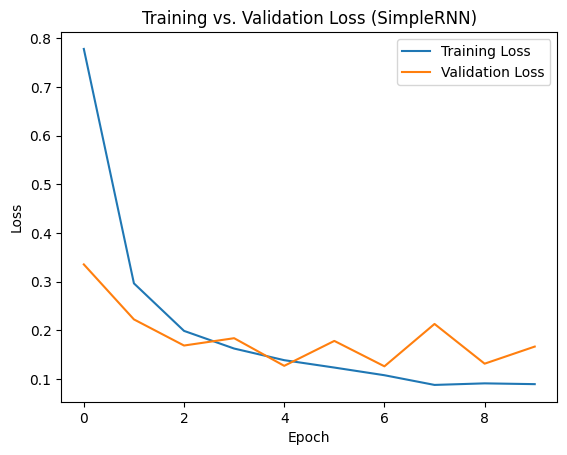

In [ ]:
# THIS ONE - graph and accuracy for each model from here on

from tensorflow.keras.layers import SimpleRNN
import matplotlib.pyplot as plt

# Define the Simple RNN model
model_rnn = Sequential([
    SimpleRNN(100, input_shape=(1, num_features)),  # 100 units in the Simple RNN layer
    Dropout(0.5),
    Dense(100, activation='relu'),                  # An additional dense layer with 100 units
    Dense(num_classes, activation='softmax')        # Output layer with softmax activation
])

# Compile the model
model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history_rnn = model_rnn.fit(
    X_train_reshaped, y_train_onehot,
    epochs=10,  # Number of epochs
    batch_size=64,  # Batch size
    validation_data=(X_test_reshaped, y_test_onehot),
    verbose=1
)

test_loss, test_acc = model_rnn.evaluate(X_test_reshaped, y_test_onehot, verbose=1)
print(f'Test accuracy: {test_acc}')

# Plot the training and validation loss
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss (SimpleRNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Model 2: Basic LSTM model

Epoch 1/10
115/115 [==============================] - 5s 14ms/step - loss: 0.7329 - accuracy: 0.6873 - val_loss: 0.3045 - val_accuracy: 0.8775
Epoch 2/10
115/115 [==============================] - 1s 13ms/step - loss: 0.2576 - accuracy: 0.8969 - val_loss: 0.1783 - val_accuracy: 0.9335
Epoch 3/10
115/115 [==============================] - 2s 14ms/step - loss: 0.1806 - accuracy: 0.9283 - val_loss: 0.1526 - val_accuracy: 0.9389
Epoch 4/10
115/115 [==============================] - 1s 13ms/step - loss: 0.1548 - accuracy: 0.9376 - val_loss: 0.2118 - val_accuracy: 0.9053
Epoch 5/10
115/115 [==============================] - 1s 9ms/step - loss: 0.1360 - accuracy: 0.9457 - val_loss: 0.1972 - val_accuracy: 0.9128
Epoch 6/10
115/115 [==============================] - 1s 9ms/step - loss: 0.1200 - accuracy: 0.9513 - val_loss: 0.1935 - val_accuracy: 0.9315
Epoch 7/10
115/115 [==============================] - 1s 9ms/step - loss: 0.1116 - accuracy: 0.9574 - val_loss: 0.1647 - val_accuracy: 0.9396
Ep

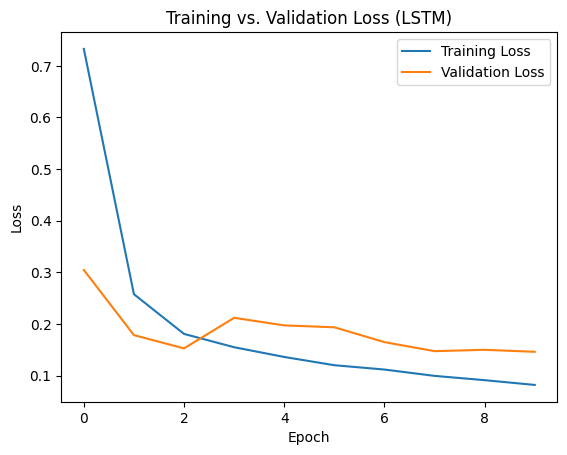

In [ ]:
# THIS ONE - include the model/graph/accuracy for this one to showcase

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

num_features = 562
num_classes = 6

model = Sequential([
    LSTM(100, input_shape=(1, num_features)),  # 100 units in the LSTM layer
    Dropout(0.5),
    Dense(100, activation='relu'),  # An additional dense layer with 100 units
    Dense(num_classes, activation='softmax')  # Output layer with softmax activation
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_reshaped, y_train_onehot,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_reshaped, y_test_onehot),
    verbose=1
)

test_loss, test_acc = model.evaluate(X_test_reshaped, y_test_onehot, verbose=1)
print(f'Test accuracy: {test_acc}')

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss (LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Model 3: GRU

Epoch 1/10
115/115 [==============================] - 5s 28ms/step - loss: 0.7338 - accuracy: 0.6959 - val_loss: 0.2956 - val_accuracy: 0.8792
Epoch 2/10
115/115 [==============================] - 3s 25ms/step - loss: 0.2568 - accuracy: 0.8970 - val_loss: 0.2274 - val_accuracy: 0.9080
Epoch 3/10
115/115 [==============================] - 2s 18ms/step - loss: 0.1857 - accuracy: 0.9257 - val_loss: 0.1493 - val_accuracy: 0.9464
Epoch 4/10
115/115 [==============================] - 2s 14ms/step - loss: 0.1505 - accuracy: 0.9393 - val_loss: 0.1988 - val_accuracy: 0.9226
Epoch 5/10
115/115 [==============================] - 1s 8ms/step - loss: 0.1322 - accuracy: 0.9472 - val_loss: 0.1986 - val_accuracy: 0.9169
Epoch 6/10
115/115 [==============================] - 1s 8ms/step - loss: 0.1212 - accuracy: 0.9529 - val_loss: 0.1789 - val_accuracy: 0.9253
Epoch 7/10
115/115 [==============================] - 1s 8ms/step - loss: 0.0986 - accuracy: 0.9622 - val_loss: 0.1412 - val_accuracy: 0.9481
Ep

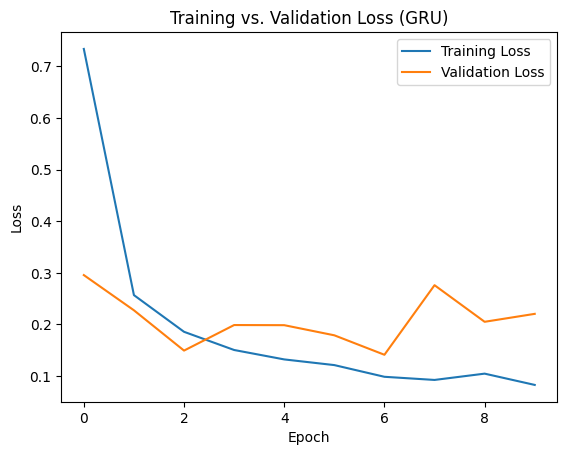

In [ ]:
from tensorflow.keras.layers import GRU
import matplotlib.pyplot as plt

# Define the GRU model
model_gru = Sequential([
    GRU(100, input_shape=(1, num_features)),        # 100 units in the GRU layer
    Dropout(0.5),
    Dense(100, activation='relu'),                  # An additional dense layer with 100 units
    Dense(num_classes, activation='softmax')        # Output layer with softmax activation
])

# Compile
model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit
history_gru = model_gru.fit(
    X_train_reshaped, y_train_onehot,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_reshaped, y_test_onehot),
    verbose=1
)

# Evaluate
test_loss, test_acc = model_gru.evaluate(X_test_reshaped, y_test_onehot, verbose=1)
print(f'Test accuracy: {test_acc}')

# Plot
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss (GRU)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Model 4: Bidirectional RNN

Epoch 1/10
115/115 [==============================] - 8s 27ms/step - loss: 0.5656 - accuracy: 0.7677 - val_loss: 0.2858 - val_accuracy: 0.8748
Epoch 2/10
115/115 [==============================] - 2s 14ms/step - loss: 0.2157 - accuracy: 0.9144 - val_loss: 0.2351 - val_accuracy: 0.8968
Epoch 3/10
115/115 [==============================] - 2s 14ms/step - loss: 0.1668 - accuracy: 0.9317 - val_loss: 0.1757 - val_accuracy: 0.9226
Epoch 4/10
115/115 [==============================] - 2s 15ms/step - loss: 0.1228 - accuracy: 0.9536 - val_loss: 0.1742 - val_accuracy: 0.9257
Epoch 5/10
115/115 [==============================] - 2s 13ms/step - loss: 0.1176 - accuracy: 0.9523 - val_loss: 0.1478 - val_accuracy: 0.9423
Epoch 6/10
115/115 [==============================] - 2s 13ms/step - loss: 0.1091 - accuracy: 0.9565 - val_loss: 0.1423 - val_accuracy: 0.9433
Epoch 7/10
115/115 [==============================] - 2s 19ms/step - loss: 0.0935 - accuracy: 0.9645 - val_loss: 0.1713 - val_accuracy: 0.9406

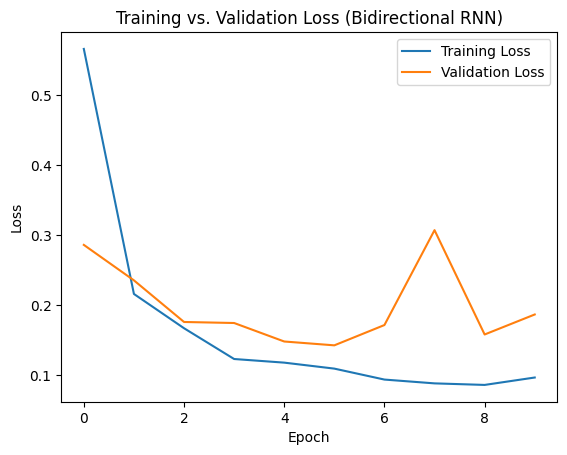

In [ ]:
from tensorflow.keras.layers import Bidirectional
import matplotlib.pyplot as plt

# Define the Bidirectional RNN model
model_bidir = Sequential([
    Bidirectional(LSTM(100, input_shape=(1, num_features))),  # 100 units in the LSTM layer, processed in both directions
    Dropout(0.5),
    Dense(100, activation='relu'),                            # An additional dense layer with 100 units
    Dense(num_classes, activation='softmax')                  # Output layer with softmax activation
])

# Compile
model_bidir.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit
history_bidir = model_bidir.fit(
    X_train_reshaped, y_train_onehot,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_reshaped, y_test_onehot),
    verbose=1
)

# Evaluate
test_loss, test_acc = model_bidir.evaluate(X_test_reshaped, y_test_onehot, verbose=1)
print(f'Test accuracy: {test_acc}')

# Plot
plt.plot(history_bidir.history['loss'], label='Training Loss')
plt.plot(history_bidir.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss (Bidirectional RNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# LSTM seemed to perform the best - albeit slightly - going to try and improve LSTM and GRU below

Epoch 1/10
115/115 [==============================] - 8s 27ms/step - loss: 0.9555 - accuracy: 0.5511 - val_loss: 0.3544 - val_accuracy: 0.8778
Epoch 2/10
115/115 [==============================] - 3s 28ms/step - loss: 0.3298 - accuracy: 0.8662 - val_loss: 0.3025 - val_accuracy: 0.8690
Epoch 3/10
115/115 [==============================] - 2s 16ms/step - loss: 0.1779 - accuracy: 0.9344 - val_loss: 0.2099 - val_accuracy: 0.9179
Epoch 4/10
115/115 [==============================] - 2s 16ms/step - loss: 0.1218 - accuracy: 0.9577 - val_loss: 0.3934 - val_accuracy: 0.8717
Epoch 5/10
115/115 [==============================] - 4s 32ms/step - loss: 0.1102 - accuracy: 0.9593 - val_loss: 0.2399 - val_accuracy: 0.9284
Epoch 6/10
115/115 [==============================] - 2s 16ms/step - loss: 0.0911 - accuracy: 0.9667 - val_loss: 0.2759 - val_accuracy: 0.9257
Epoch 7/10
115/115 [==============================] - 2s 19ms/step - loss: 0.1297 - accuracy: 0.9536 - val_loss: 0.2095 - val_accuracy: 0.9413

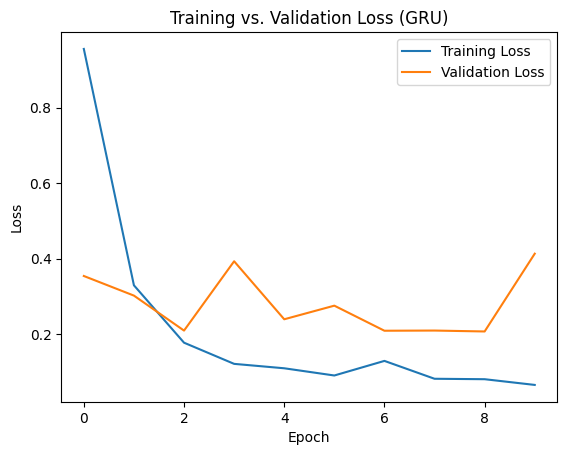

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense

# Define a more complex GRU model
model_gru = Sequential([
    GRU(100, return_sequences=True, input_shape=(1, num_features)), # First GRU layer
    GRU(100, return_sequences=True),                                # Second GRU layer
    GRU(100),                                                       # Third GRU layer, does not return sequences
    Dropout(0.8),                                                   # experimented with different dropouts - 0.2 much worse, 0.8 close to 0.5 results
    Dense(100, activation='relu'),                                  # Additional dense layer with 100 units
    Dense(num_classes, activation='softmax')                        # Output layer with softmax activation
])

# Compile
model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit
history_gru = model_gru.fit(
    X_train_reshaped, y_train_onehot,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_reshaped, y_test_onehot),
    verbose=1
)

# Evaluate
test_loss, test_acc = model_gru.evaluate(X_test_reshaped, y_test_onehot, verbose=1)
print(f'Test accuracy: {test_acc}')

# Plot
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss (GRU)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model messing around with to try and improve

Epoch 1/10
115/115 [==============================] - 4s 15ms/step - loss: 0.9887 - accuracy: 0.5680 - val_loss: 0.4664 - val_accuracy: 0.7818
Epoch 2/10
115/115 [==============================] - 1s 12ms/step - loss: 0.4059 - accuracy: 0.8289 - val_loss: 0.2499 - val_accuracy: 0.8999
Epoch 3/10
115/115 [==============================] - 2s 16ms/step - loss: 0.2715 - accuracy: 0.8902 - val_loss: 0.2261 - val_accuracy: 0.9070
Epoch 4/10
115/115 [==============================] - 2s 13ms/step - loss: 0.2157 - accuracy: 0.9162 - val_loss: 0.2081 - val_accuracy: 0.9270
Epoch 5/10
115/115 [==============================] - 1s 9ms/step - loss: 0.1900 - accuracy: 0.9259 - val_loss: 0.1369 - val_accuracy: 0.9474
Epoch 6/10
115/115 [==============================] - 1s 9ms/step - loss: 0.1732 - accuracy: 0.9342 - val_loss: 0.1340 - val_accuracy: 0.9474
Epoch 7/10
115/115 [==============================] - 1s 10ms/step - loss: 0.1482 - accuracy: 0.9422 - val_loss: 0.1596 - val_accuracy: 0.9345
E

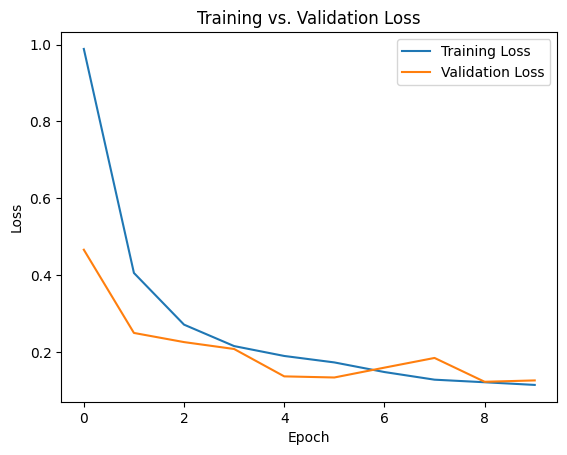

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

num_features = 562
num_classes = 6

# model = Sequential([
    # LSTM layer to process each sequence, one timestep at a time
    # LSTM(100, input_shape=(1, num_features)),  # 100 units to capture sequence complexity
    # Dropout(0.5, name='dropout_layer'),  # Dropout to help overfitting - 0.2 much worse, 0.8 was similar
    # Dense(100, activation='relu'),  # Dense layer for pattern recognition after LSTM processing
    # Dense(50, activation='relu'),  # Additional Dense layer for further pattern recognition
    # Dense(num_classes, activation='softmax')  # softmax for multi-class classification
# ])

model = Sequential([
    # LSTM layer to process each sequence, one timestep at a time
    LSTM(100, input_shape=(1, num_features)),
    Dropout(0.5, name='dropout_layer'),
    Dense(100, activation='relu'),
    Dropout(0.5),  # Additional Dropout layer to help prevent overfitting
    Dense(num_classes, activation='softmax')
])

#optimizer = Adam(learning_rate=0.001)  # Trying different learning rates
# 0.1 terrible - way too high
# 0.01 - potential - would need to try much higher epochs though to fully check
# 0.001 - not bad - overfits around ~5 epochs like other models above
# 0.0001 - worse accuracy - overfits around ~13 epochs

# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# default better overall
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_reshaped, y_train_onehot,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_reshaped, y_test_onehot),
    verbose=1
)

test_loss, test_acc = model.evaluate(X_test_reshaped, y_test_onehot, verbose=1)
print(f'Test accuracy: {test_acc:.4f}')

# Plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()